<img style="float: left; height:150px; padding-right: 50px" src="http://3.bp.blogspot.com/-DC7b1EkdbSU/TkxsKQbCQsI/AAAAAAAAAAY/YT3sDZTyKNQ/s1600/AAguy.jpg"/>
* Jon Madison  
* Created 11/17/2016
* [ufo data from Kaggle](https://www.kaggle.com/NUFORC/ufo-sightings)

# Reported UFO Sightings

**The data looked interesting to me, and it's always fun to speculate on UFOs, so i'm not sure what i want to find out from it. So let's take a look.**

In [1]:
import pandas as pd
import pandasql as pdsql
import numpy as np
import matplotlib.pyplot as plt
plt.xkcd()

In [2]:
ufo = pd.read_csv('./data/ufo/scrubbed.csv', low_memory=False)

There was a complete version, and a scrubbed version. I opted for the "scrubbed" version, which still isn't as scrubbed as much as i'll need it for my analysis, so here we go.

In [3]:
ufo.columns

Index(['datetime', 'city', 'state', 'country', 'shape', 'duration (seconds)',
       'duration (hours/min)', 'comments', 'date posted', 'latitude',
       'longitude '],
      dtype='object')

In [4]:
ufo.describe(include='all')

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
count,80332,80332,74535,70662,78400,80332,80332,80317,80332,80332,80332.000000
unique,69586,19900,67,5,29,537,8349,79997,317,18445,NaN
top,7/4/2010 22:00,seattle,ca,us,light,300,5 minutes,Fireball,12/12/2009,47.6063889,NaN
freq,36,525,9655,65114,16565,8635,4716,11,1510,581,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-86.772885
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.697205
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-176.658056
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-112.073333
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-87.903611
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-78.755000


Oh...

In [5]:
ufo_count = len(ufo)
ufo_count

80332

In [6]:
ufo.loc[:3]

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833


** Cleanup time. Start by looking at the NaNs. Are there enough in significant areas to deal with? **

In [7]:
for col in ufo.columns:
    if ufo[col].hasnans:
        print(col)

state
country
shape
comments


Has nans. How big is the problem?

In [8]:
def calcnan(col):
    if ufo[col].hasnans:
        percent_null = (sum(pd.isnull(ufo[col])) / ufo_count) * 100
        print(col, str(percent_null) + "% NaN")
        return percent_null
          
l = list(map(lambda col: calcnan(col), ufo.columns))
sum(filter(None, l))

state 7.21630234527% NaN
country 12.0375441916% NaN
shape 2.40501917044% NaN
comments 0.0186725090873% NaN


21.677538216401935

21% of our records have this problem. sigh. I can't just use an ax (aka hasnans)

In [9]:
df = pdsql.sqldf("SELECT * from ufo WHERE country is null and state is not null")
len(df)

6414

Well here's low hanging fruit -- get the country right on the records by looking at the state, at least for US states...

In [10]:
us_states = [ 'ak','az','ar','ca','co','ct','de','fl','ga','hi','id','il','in','ia','ks','ky','la','me','md','ma','mi','mn','ms','mo','mt','ne','nv','nh','nj','nm','ny','nc','nd','oh','ok','or','pa','ri','sc','sd','tn','tx','ut','vt','va','wa','wv','wi','wy' ]

In [11]:
def set_country_from_state(row):
    #print("state", row.state)
    if type(row.state) is not str:
        return row.country
    elif row.state.strip() in us_states:
        #print("got a US state", row.state)
        return "us"
    else:
        return row.country         

let's try one...

In [12]:
set_country_from_state(df.loc[0])

'us'

This looks good, let's run it on the dataset:

In [13]:
range(len(ufo))

range(0, 80332)

In [14]:

ufo["country"] = [set_country_from_state(ufo.loc[i]) for i in range(len(ufo))]

How'd it do?

In [15]:
df = pdsql.sqldf("SELECT * from ufo WHERE country is null AND state is not null")

In [16]:
len(df)

748

Good enough for now, i must move on to the next...

### Things I'd like to find out:
* Year with the most sightings
* Locale with most sightings (state? region?)

### Things I'd like to predict:
* Are people in smaller cities more likely to sight UFO's?
* Are there times that people are more likely report when they have seen UFOs?

### General:
* Do some unsupervised learning to discover clusters

So, to begin, if i want to work with the date and times, i'll have to do some parsing out. praying that the datetime field is consistent...

In [17]:
type(ufo.datetime[0])

str

It's a string, yep, so let me try to run a converter, and add a column that separates the time from the date of the sighting.

In [18]:
date_ex = ufo.datetime[0]
print("converting", date_ex)
pd.datetime.strptime(date_ex, '%d/%m/%Y %H:%M')


converting 10/10/1949 20:30


datetime.datetime(1949, 10, 10, 20, 30)

well...tried to convert all:

ufo['datetime'] = pd.to_datetime(ufo['datetime'], format='%d/%m/%Y %H:%M')

turns out that some of the times are 24:nn --how many of these are there? T.T

In [21]:
pdsql.sqldf("SELECT datetime from ufo WHERE datetime like '%24:%'").size

694

ugh. i have a mind to just nix them but, sigh, let's convert to string

In [22]:
def convert24(date_str):
    #print (convert24, date_str)
    import re
    match=re.search(r'^(\d{1,2}\/\d{1,2}\/\d{4})\ (\d{2}):(\d{2})', date_str)
    if match:
        if(match.group(2) == "24"):
            output = match.group(1)+' 00:'+match.group(3)
        else:
            output = date_str
        return output
    else:
        return ""

In [23]:
convert24('10/18/1949 24:40')

'10/18/1949 00:40'

In [24]:
convert24('10/18/1949 13:40')

'10/18/1949 13:40'

In [25]:
def set_hour_from_datetime(row):
    if type(row.datetime) is str:
        d = convert24(row.datetime)
        #print(row.datetime, "->", d)
        d = pd.datetime.strptime(d,'%m/%d/%Y %H:%M')
        #print("got ", d.hour, "from", row.datetime)
        return d.hour
    else:
        return 0

In [26]:
def set_year_from_datetime(row):
    if type(row.datetime) is str:
        d = convert24(row.datetime)
        #print(row.datetime, "->", d)
        d = pd.datetime.strptime(d,'%m/%d/%Y %H:%M')
        #print("got ", d.hour, "from", row.datetime)
        return d.year
    else:
        return 0

In [27]:
#introduce new hour column

ufo["hour"] = [set_hour_from_datetime(ufo.loc[i]) for i in range(len(ufo))]

In [28]:
ufo["year"] = [set_year_from_datetime(ufo.loc[i]) for i in range(len(ufo))]

**At this point, there's probably more cleanup, but i need to spend time analyzing data.**

## Sightings over the years

First off, need to aggregate sightings per year

In [30]:
ufo = ufo.sort_values(['year'], ascending=True )

In [31]:
len(ufo[ufo["year"] == 1949])

16

In [32]:
sighting_year = ufo.year.unique()

sighting_count = [len(ufo[ufo["year"] == year]) for year in ufo.year.unique()]

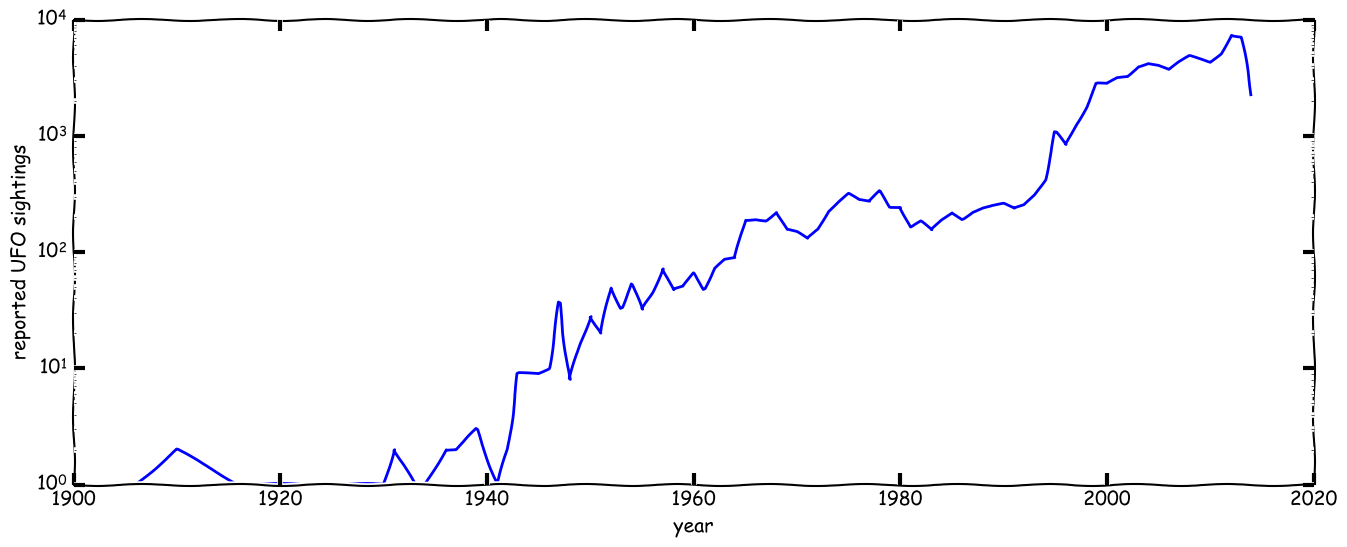

In [33]:
plt.figure(figsize=(16,6))
plt.plot(sighting_year,sighting_count)
plt.xlabel("year")
plt.ylabel("reported UFO sightings")
plt.yscale('log')
plt.show()

In [34]:
most_sightings = sighting_year[np.argmax(sighting_count)]

In [35]:
print(str(most_sightings), "was the year with the most reported UFO sightings")

2012 was the year with the most reported UFO sightings


In [36]:
ufo = ufo.dropna()

In [37]:
ufo.describe(include='all')

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,hour,year
count,72009,72009,72009,72009,72009,72009,72009,72009,72009,72009,72009.000000,72009.000000,72009.000000
unique,62516,15830,67,4,29,491,7576,71728,316,15403,NaN,NaN,NaN
top,7/4/2010 22:00,seattle,ca,us,light,300,5 minutes,Fireball,12/12/2009,47.6063889,NaN,NaN,NaN
freq,36,472,9404,69054,15276,7808,4384,10,1368,525,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-95.222753,15.611868,2004.044258
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.924438,7.688726,10.464761
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-176.658056,0.000000,1910.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-114.115554,10.000000,2001.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-89.543889,19.000000,2007.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-80.324775,21.000000,2011.000000
